<a href="https://colab.research.google.com/github/morutkin/MLProject/blob/master/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 Step Character Translation Pipeline 

Step 1: Detection 
* Detecting the average character size per image using CenterNet 
* Using the above model to then create the bounding boxes with character location prediction 

Step 2: Classification 
* Using CNN with ResNet Backbone for classifying the characters with unicode

Backbone of this process of creating a CenterNet is attributed to K_Mat's Kernel on Kaggle 




### Connect To Google Drive 

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


### Install Kuzushiji Kaggle Sets On The Drive 

In [0]:
pip install kaggle

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download  -c kuzushiji-recognition -p /content/kaggle

### Imports 

In [0]:
import numpy as np
import json
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import os  
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.objectives import mean_squared_error
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path
#import mmcv
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensor
import torch.utils.data
#from mmdet.core.bbox import bbox_overlaps
import cv2

from google.colab import drive
drive.mount('/content/drive')

### Install OpenCV + Albumenations + Keras + Tensorflow 

In [0]:
!pip3 install opencv-python

In [0]:
pip install --upgrade tqdm opencv-python==3.4.5.20 timm --user

In [0]:
pip install --upgrade git+https://github.com/albu/albumentations --user

In [0]:
!pip3 install Keras

In [0]:
!pip3 install Tensorflow

In [0]:
!pip install tensorflow-gpu==2.0.0 tensorflow-addons

## Data Unpacking 

### Unzipping Files + File Placements 

In [0]:
#unzip pictures in train 

import zipfile

with zipfile.ZipFile('/content/kaggle/train_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/train_images')

with zipfile.ZipFile('/content/kaggle/test_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/test_images')

with zipfile.ZipFile('/content/kaggle/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/train.csv')

In [0]:
# data frame of ["100241706_00004_2", U+309D 1076 3545 31 71 ...]
#second part is unicode, x, y, w, h for all chars 
train_set = pd.read_csv('/content/kaggle/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"', keep_default_na=False)
train_set=train_set.dropna(axis=0, how='any')
train_set=train_set.reset_index(drop=True)
#print(train_set.head())
#print(train_set["labels"])

# data frame of ["U+0031", "𠀋"]
unimap = pd.read_csv('/content/kaggle/unicode_translation.csv')
sample_submiss = pd.read_csv('/content/kaggle/sample_submission.csv')

#image directories 
img_dir = Path('/content/kaggle/train_images')
img_dirTest = Path('/content/kaggle/test_images')

## Pre-Processing 

### Image Cropping 

In [0]:
#cut each character with corresponding unicode translated label
def cropImage(labels, loop1_index, img_dir):
  """
  reading images from train: imread
  a pixel array in BGR format 

  [[[ 72  99 143]
    [ 76 103 147]
    [ 78 106 147]
    ..., 
    [159 186 207]
    [160 187 213]
    [157 187 212]]
  """
  img = cv2.imread(im_dir)
  # convert image to RGB color for matplotlib
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  labels = labels.split(" ")

  #maps {unicode -> x, y, w, h}
  labels[::5] = map(unicodeToInt, labels[::5])
  unicode = labels[::5]
  print(unicode)
  del labels[::5] # deletes the one thats captured 

  labels = np.array(labels, dtype=np.int16)
  labels = labels.reshape(-1,4)

  labels[:, 2] = np.sum(a=labels[:,[0,2]], axis=1)
  labels[:, 3] = np.sum(a=labels[:,[1,3]], axis=1)

  [Image.fromarray(img[label[1]:label[3], label[0]:label[2]]).save(f"{CHARS}/{unicode[loop2_index]}_{loop1_index}-{loop2_index}.jpg") for loop2_index,label in enumerate(labels)]
  

In [0]:
def RandomCrop(image: Image.Image) -> Image.Image:
  img_w, img_h = image.size
  assert 0.5 < scale_range[0] < scale_range[1] <= 1
  self.scale_range = scale_range
  self.translation_range = translation_range
  self.size = size
  crop_w = int(img_w * np.random.uniform(*self.scale_range))
  crop_h = int(img_h * np.random.uniform(*self.scale_range))
  dx = int(round(img_w * np.random.uniform(*self.translation_range) / 1.4))
  dy = int(round(img_h * np.random.uniform(*self.translation_range) / 1.4))
  x = (img_w - crop_w) // 2 + dx
  y = (img_h - crop_h) // 2 + dy
  cropped = image.crop((x, y, x + crop_w, y + crop_h))
  resized = cropped.resize(self.size, resample=Image.BILINEAR)
  return resized

## Character size distribution

We want to predict the average letter size in order to know where to look for when creating the bounding boxes, we're using a Centernet backbone modeled off of K_mat in the Kaggle Competition 

In [0]:
path_1="/content/kaggle/train.csv"
path_2="/content/kaggle/train_images/"
path_3="/content/kaggle/test_images/"
path_4="/content/kaggle/sample_submission.csv"

Making train into a DF + preprocessing by dropping NAs

In [0]:
import matplotlib.pyplot as plt

#train data 
df_train=pd.read_csv('/content/kaggle/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train=df_train.dropna(axis=0, how='any') #you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)


making a:

* category_names: unicode names
* dict_cat
* inv_dict_cat
* annotation_list_train
[pic_path_name, path to cat# and annotations [x,y,w,h]]


In [0]:
annotation_list_train=[]
category_names=set()

for i in range(len(df_train)):
  ann=np.array(df_train.loc[i,"labels"].split(" ")).reshape(-1,5) # cat,x,y,width,height for each picture
  category_names=category_names.union({i for i in ann[:,0]})

#just the existing unicode labels 
print("category_names")  
print(category_names)

category_names=sorted(category_names)
dict_cat={list(category_names)[j]:str(j) for j in range(len(category_names))}
# {unicode: placement # }
print("dict_cat")  
print(dict_cat)

inv_dict_cat={str(j):list(category_names)[j] for j in range(len(category_names))}
# {placement #: unicode }
print("inv_dict_cat")  
print(inv_dict_cat)

  
for i in range(len(df_train)):
  ann=np.array(df_train.loc[i,"labels"].split(" ")).reshape(-1,5)#cat,left,top,width,height for each picture
  for j,category_name in enumerate(ann[:,0]):
    ann[j,0]=int(dict_cat[category_name])  
  ann=ann.astype('int32')
  ann[:,1]+=ann[:,3]//2 #center_x
  ann[:,2]+=ann[:,4]//2 #center_y
  annotation_list_train.append(["{}{}.jpg".format(path_2,df_train.loc[i,"image_id"]),ann])
# annotation_list_train contains [path-to-pic, list of cat# bottom top width height ]
# annotation_list_train [0][0] = path to picture 
# annotation_list_train [0][1] = path to cat# and annotations  


print("sample image")
input_width,input_height=1024, 1024
img = np.asarray(Image.open(annotation_list_train[0][0]).resize((input_width,input_height)).convert('RGB'))
plt.imshow(img)
plt.show()

get directory of test images

In [0]:
# get directory of test images
df_submission=pd.read_csv(path_4)
id_test=path_3+df_submission["image_id"]+".jpg"

Making a directory of the average letter sizes for each image according to how many supposed labels are in each picture. 

We then save the [image path, log of average letter size] in the resized/ directory  

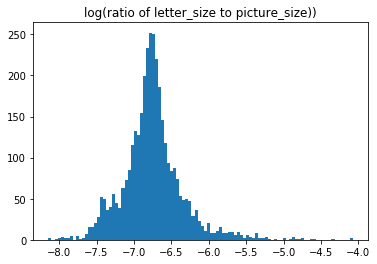

In [0]:
aspect_ratio_pic_all=[]
aspect_ratio_pic_all_test=[]
average_letter_size_all=[]
train_input_for_size_estimate=[]
resize_dir="resized/"

#make a directory of the resized images size estimates  
if os.path.exists(resize_dir) == False:os.mkdir(resize_dir)

for i in range(len(annotation_list_train)):
    with Image.open(annotation_list_train[i][0]) as f:
        width,height=f.size
        area=width*height
        aspect_ratio_pic=height/width
        aspect_ratio_pic_all.append(aspect_ratio_pic)
        letter_size=annotation_list_train[i][1][:,3]*annotation_list_train[i][1][:,4]
        letter_size_ratio=letter_size/area
    
        average_letter_size=np.mean(letter_size_ratio)
        average_letter_size_all.append(average_letter_size)
        train_input_for_size_estimate.append([annotation_list_train[i][0],np.log(average_letter_size)])
    

for i in range(len(id_test)):
    with Image.open(id_test[i]) as f:
        width,height=f.size
        aspect_ratio_pic=height/width
        aspect_ratio_pic_all_test.append(aspect_ratio_pic)


plt.hist(np.log(average_letter_size_all),bins=100)
plt.title('log(ratio of letter_size to picture_size))',loc='center',fontsize=12)
plt.show()

* Random crop of images within the random range of 70-100% of its original size 
* converts image to RGB which is easier to work with using Tensorflow 
* outputs array of the new image dimentions 


In [0]:
category_n=1
import cv2
input_width,input_height=512, 512

def Datagen_sizecheck_model(filenames, batch_size, size_detection_mode=True, is_train=True,random_crop=True):
  x=[]
  y=[]
  
  count=0

  while True:
    for i in range(len(filenames)):
      if random_crop:
        crop_ratio=np.random.uniform(0.7,1)
      else:
        crop_ratio=1
      with Image.open(filenames[i][0]) as f:
        #random crop
        if random_crop and is_train:
          pic_width,pic_height=f.size
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)
          top_offset=np.random.randint(0,pic_height-int(crop_ratio*pic_height))
          left_offset=np.random.randint(0,pic_width-int(crop_ratio*pic_width))
          bottom_offset=top_offset+int(crop_ratio*pic_height)
          right_offset=left_offset+int(crop_ratio*pic_width)
          f=cv2.resize(f[top_offset:bottom_offset,left_offset:right_offset,:],(input_height,input_width))
        else:
          f=f.resize((input_width, input_height))
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)          
        x.append(f)
      
      
      if random_crop and is_train:
        y.append(filenames[i][1]-np.log(crop_ratio))
      else:
        y.append(filenames[i][1])
      
      count+=1
      if count==batch_size:
        x=np.array(x, dtype=np.float32)
        y=np.array(y, dtype=np.float32)

        inputs=x/255
        targets=y       
        x=[]
        y=[]
        count=0
        yield inputs, targets

### CenterNet For Ideal Image Size 

#### Blocks of layers for CenterNet

In [0]:
def aggregation_block(x_shallow, x_deep, deep_ch, out_ch):
  x_deep= Conv2DTranspose(deep_ch, kernel_size=2, strides=2, padding='same', use_bias=False)(x_deep)
  x_deep = BatchNormalization()(x_deep)   
  x_deep = LeakyReLU(alpha=0.1)(x_deep)
  x = Concatenate()([x_shallow, x_deep])
  x=Conv2D(out_ch, kernel_size=1, strides=1, padding="same")(x)
  x = BatchNormalization()(x)   
  x = LeakyReLU(alpha=0.1)(x)
  return x

def cbr(x, out_layer, kernel, stride):
  x=Conv2D(out_layer, kernel_size=kernel, strides=stride, padding="same")(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  return x

def resblock(x_in,layer_n):
  x=cbr(x_in,layer_n,3,1)
  x=cbr(x,layer_n,3,1)
  x=Add()([x,x_in])
  return x  

### Creating the model 

The ENCODER:
* extracts features and reduces dimentions through each layer 

The DECODER:
* inverts the process and reverts the layers into being interpretable again

This is the literal CenterNet  

In [0]:
def create_model(input_shape, size_detection_mode=True, aggregation=True):
    input_layer = Input(input_shape)
    
    #resized input
    input_layer_1=AveragePooling2D(2)(input_layer)
    input_layer_2=AveragePooling2D(2)(input_layer_1)

    #### ENCODER ####

    x_0= cbr(input_layer, 16, 3, 2)#512->256
    concat_1 = Concatenate()([x_0, input_layer_1])

    x_1= cbr(concat_1, 32, 3, 2)#256->128
    concat_2 = Concatenate()([x_1, input_layer_2])

    x_2= cbr(concat_2, 64, 3, 2)#128->64
    
    x=cbr(x_2,64,3,1)
    x=resblock(x,64)
    x=resblock(x,64)
    
    x_3= cbr(x, 128, 3, 2)#64->32
    x= cbr(x_3, 128, 3, 1)
    x=resblock(x,128)
    x=resblock(x,128)
    x=resblock(x,128)
    
    x_4= cbr(x, 256, 3, 2)#32->16
    x= cbr(x_4, 256, 3, 1)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
    x=resblock(x,256)
 
    x_5= cbr(x, 512, 3, 2)#16->8
    x= cbr(x_5, 512, 3, 1)
    
    x=resblock(x,512)
    x=resblock(x,512)
    x=resblock(x,512)
    
    if size_detection_mode:
      x=GlobalAveragePooling2D()(x)
      x=Dropout(0.2)(x)
      out=Dense(1,activation="linear")(x)
    
    else:#centernet mode
    #### DECODER ####
      x_1= cbr(x_1, output_layer_n, 1, 1)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      x_2= cbr(x_2, output_layer_n, 1, 1)
      x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      x_3= cbr(x_3, output_layer_n, 1, 1)
      x_3 = aggregation_block(x_3, x_4, output_layer_n, output_layer_n) 
      x_2 = aggregation_block(x_2, x_3, output_layer_n, output_layer_n)
      x_1 = aggregation_block(x_1, x_2, output_layer_n, output_layer_n)
      
      x_4= cbr(x_4, output_layer_n, 1, 1)

      x=cbr(x, output_layer_n, 1, 1)
      x= UpSampling2D(size=(2, 2))(x)#8->16 tconvのがいいか

      x = Concatenate()([x, x_4])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#16->32
    
      x = Concatenate()([x, x_3])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#32->64   128のがいいかも？ 
    
      x = Concatenate()([x, x_2])
      x=cbr(x, output_layer_n, 3, 1)
      x= UpSampling2D(size=(2, 2))(x)#64->128 
      
      x = Concatenate()([x, x_1])
      x=Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
      out = Activation("sigmoid")(x)
    
    model=Model(input_layer, out)
    
    return model

def model_fit_sizecheck_model(model,train_list,cv_list,n_epoch,batch_size=32):
    hist = model.fit_generator(
        Datagen_sizecheck_model(train_list,batch_size, is_train=True,random_crop=True),
        steps_per_epoch = len(train_list) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen_sizecheck_model(cv_list,batch_size, is_train=False,random_crop=False),
        validation_steps = len(cv_list) // batch_size,
        callbacks = [lr_schedule, model_checkpoint],#[early_stopping, reduce_lr, model_checkpoint],
        shuffle = True,
        verbose = 1
    )
    return hist

Create the instance of the Model with the following params + save weights  

In [0]:
K.clear_session()
model=create_model(input_shape=(input_height,input_width,3),size_detection_mode=True)

def lrs(epoch):
    lr = 0.0005
    if epoch>10:
        lr = 0.0001
    return lr


lr_schedule = LearningRateScheduler(lrs)
model_checkpoint = ModelCheckpoint("final_weights_step1.hdf5", monitor = 'val_loss', verbose = 1,
                                      save_best_only = True, save_weights_only = True, period = 1)
print(model.summary())

In [0]:
train_list, cv_list = train_test_split(train_input_for_size_estimate, random_state = 111,test_size = 0.2)


learning_rate=0.0005
n_epoch=3
batch_size=13

model.compile(loss=mean_squared_error, optimizer=Adam(lr=learning_rate))
hist = model_fit_sizecheck_model(model,train_list,cv_list,n_epoch,batch_size)

#model.save_weights('final_weights_step1.h5')
model.load_weights('final_weights_step1.hdf5')

Epoch 1/3
 55/221 [======>.......................] - ETA: 3:47 - loss: 13.0995
Epoch 00001: val_loss improved from inf to 13.09954, saving model to final_weights_step1.hdf5
221/221 [==============================] - 414s 2s/step - loss: 3.9850 - val_loss: 13.0995
Epoch 2/3
 55/221 [======>.......................] - ETA: 3:33 - loss: 0.1845
Epoch 00002: val_loss improved from 13.09954 to 0.18455, saving model to final_weights_step1.hdf5
221/221 [==============================] - 380s 2s/step - loss: 0.7048 - val_loss: 0.1845
Epoch 3/3
 55/221 [======>.......................] - ETA: 3:33 - loss: 0.3856
Epoch 00003: val_loss did not improve from 0.18455
221/221 [==============================] - 375s 2s/step - loss: 0.6529 - val_loss: 0.3856


### Results For Letter Size 
Based on the detector, the split size is determined for each picture

In [0]:
predict = model.predict_generator(Datagen_sizecheck_model(cv_list,batch_size, is_train=False,random_crop=False),
                                  steps=len(cv_list) // batch_size)
target=[cv[1] for cv in cv_list]
plt.scatter(predict,target[:len(predict)])
plt.title('---letter_size/picture_size--- estimated vs target ',loc='center',fontsize=10)
plt.show()

In [0]:
batch_size=1
predict_train = model.predict_generator(Datagen_sizecheck_model(train_input_for_size_estimate,batch_size, is_train=False,random_crop=False, ),
                                  steps=len(train_input_for_size_estimate)//batch_size)

### CenterNet based off of the image detection sizes are determined for the ideal cropping of the pictures. The CenterNet used to detect character sizes below takes it into consideration 

In [0]:
category_n=1
output_layer_n=category_n+4
output_height,output_width=128,128
​
i=0
​
h_split=annotation_list_train_w_split[i][2]
w_split=annotation_list_train_w_split[i][3]
max_crop_ratio_h=1/h_split
max_crop_ratio_w=1/w_split
crop_ratio=np.random.uniform(0.5,1)
crop_ratio_h=max_crop_ratio_h*crop_ratio
crop_ratio_w=max_crop_ratio_w*crop_ratio
​
with Image.open(annotation_list_train_w_split[i][0]) as f:
        
        #random crop
        pic_width,pic_height=f.size
        f=np.asarray(f.convert('RGB'),dtype=np.uint8)
        top_offset=np.random.randint(0,pic_height-int(crop_ratio_h*pic_height))
        left_offset=np.random.randint(0,pic_width-int(crop_ratio_w*pic_width))
        bottom_offset=top_offset+int(crop_ratio_h*pic_height)
        right_offset=left_offset+int(crop_ratio_w*pic_width)
        img=cv2.resize(f[top_offset:bottom_offset,left_offset:right_offset,:],(input_height,input_width))
​
      
      
output_layer=np.zeros((output_height,output_width,(output_layer_n+category_n)))
for annotation in annotation_list_train_w_split[i][1]:
​
          x_c=(annotation[1]-left_offset)*(output_width/int(crop_ratio_w*pic_width))
          y_c=(annotation[2]-top_offset)*(output_height/int(crop_ratio_h*pic_height))
          width=annotation[3]*(output_width/int(crop_ratio_w*pic_width))
          height=annotation[4]*(output_height/int(crop_ratio_h*pic_height))
          
          top=np.maximum(0,y_c-height/2)
          left=np.maximum(0,x_c-width/2)
          bottom=np.minimum(output_height,y_c+height/2)
          right=np.minimum(output_width,x_c+width/2)
          
          if top>=output_height or left>=output_width or bottom<=0 or right<=0:#random crop(エリア外の除去)
            continue
          width=right-left
          height=bottom-top
          x_c=(right+left)/2
          y_c=(top+bottom)/2
          
        
        
          category=0#not classify
          heatmap=((np.exp(-(((np.arange(output_width)-x_c)/(width/10))**2)/2)).reshape(1,-1)
                            *(np.exp(-(((np.arange(output_height)-y_c)/(height/10))**2)/2)).reshape(-1,1))
          output_layer[:,:,category]=np.maximum(output_layer[:,:,category],heatmap[:,:])
          output_layer[int(y_c//1),int(x_c//1),category_n+category]=1
          output_layer[int(y_c//1),int(x_c//1),2*category_n]=y_c%1#height offset
          output_layer[int(y_c//1),int(x_c//1),2*category_n+1]=x_c%1
          output_layer[int(y_c//1),int(x_c//1),2*category_n+2]=height/output_height
          output_layer[int(y_c//1),int(x_c//1),2*category_n+3]=width/output_width
​
fig, axes = plt.subplots(1, 3,figsize=(15,15))
axes[0].set_axis_off()
axes[0].imshow(img)
axes[1].set_axis_off()
axes[1].imshow(output_layer[:,:,1])
axes[2].set_axis_off()
axes[2].imshow(output_layer[:,:,0])
plt.show()

## Actual Detector CenterNet
Input of CenterNet:

* Cropped image resized into 512x512x3

Output of CenterNet:

* Heatmap of center point 128x128x1

* x-offset and y-offset of the center point inside the detected cell 128x128x2

* width and height of the the detected object 128x128x2

In [0]:
category_n=1
output_layer_n=category_n+4
output_height,output_width=128,128
​
def Datagen_centernet(filenames, batch_size):
  x=[]
  y=[]
  
  count=0
​
  while True:
    for i in range(len(filenames)):
      h_split=filenames[i][2]
      w_split=filenames[i][3]
      max_crop_ratio_h=1/h_split
      max_crop_ratio_w=1/w_split
      crop_ratio=np.random.uniform(0.5,1)
      crop_ratio_h=max_crop_ratio_h*crop_ratio
      crop_ratio_w=max_crop_ratio_w*crop_ratio
      
      with Image.open(filenames[i][0]) as f:
        
        #random crop
        
        pic_width,pic_height=f.size
        f=np.asarray(f.convert('RGB'),dtype=np.uint8)
        top_offset=np.random.randint(0,pic_height-int(crop_ratio_h*pic_height))
        left_offset=np.random.randint(0,pic_width-int(crop_ratio_w*pic_width))
        bottom_offset=top_offset+int(crop_ratio_h*pic_height)
        right_offset=left_offset+int(crop_ratio_w*pic_width)
        f=cv2.resize(f[top_offset:bottom_offset,left_offset:right_offset,:],(input_height,input_width))
        x.append(f)      
​
      output_layer=np.zeros((output_height,output_width,(output_layer_n+category_n)))
      for annotation in filenames[i][1]:
        x_c=(annotation[1]-left_offset)*(output_width/int(crop_ratio_w*pic_width))
        y_c=(annotation[2]-top_offset)*(output_height/int(crop_ratio_h*pic_height))
        width=annotation[3]*(output_width/int(crop_ratio_w*pic_width))
        height=annotation[4]*(output_height/int(crop_ratio_h*pic_height))
        top=np.maximum(0,y_c-height/2)
        left=np.maximum(0,x_c-width/2)
        bottom=np.minimum(output_height,y_c+height/2)
        right=np.minimum(output_width,x_c+width/2)
          
        if top>=(output_height-0.1) or left>=(output_width-0.1) or bottom<=0.1 or right<=0.1:#random crop(out of picture)
          continue
        width=right-left
        height=bottom-top
        x_c=(right+left)/2
        y_c=(top+bottom)/2
​
        
        category=0#not classify, just detect
        heatmap=((np.exp(-(((np.arange(output_width)-x_c)/(width/10))**2)/2)).reshape(1,-1)
                            *(np.exp(-(((np.arange(output_height)-y_c)/(height/10))**2)/2)).reshape(-1,1))
        output_layer[:,:,category]=np.maximum(output_layer[:,:,category],heatmap[:,:])
        output_layer[int(y_c//1),int(x_c//1),category_n+category]=1
        output_layer[int(y_c//1),int(x_c//1),2*category_n]=y_c%1#height offset
        output_layer[int(y_c//1),int(x_c//1),2*category_n+1]=x_c%1
        output_layer[int(y_c//1),int(x_c//1),2*category_n+2]=height/output_height
        output_layer[int(y_c//1),int(x_c//1),2*category_n+3]=width/output_width
      y.append(output_layer)  
    
      count+=1
      if count==batch_size:
        x=np.array(x, dtype=np.float32)
        y=np.array(y, dtype=np.float32)
​
        inputs=x/255
        targets=y       
        x=[]
        y=[]
        count=0
        yield inputs, targets
​
def all_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    alpha=2.
    beta=4.
​
    heatmap_true_rate = K.flatten(y_true[...,:category_n])
    heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
    heatmap_pred = K.flatten(y_pred[...,:category_n])
    heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
    sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
    
    all_loss=(heatloss+1.0*offsetloss+5.0*sizeloss)/N
    return all_loss
​
def size_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
    return (5*sizeloss)/N
​
def offset_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
    return (offsetloss)/N
  
def heatmap_loss(y_true, y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    alpha=2.
    beta=4.
​
    heatmap_true_rate = K.flatten(y_true[...,:category_n])
    heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
    heatmap_pred = K.flatten(y_pred[...,:category_n])
    heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    return heatloss/N
​
  
def model_fit_centernet(model,train_list,cv_list,n_epoch,batch_size=32):
    hist = model.fit_generator(
        Datagen_centernet(train_list,batch_size),
        steps_per_epoch = len(train_list) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen_centernet(cv_list,batch_size),
        validation_steps = len(cv_list) // batch_size,
        callbacks = [lr_schedule],#early_stopping, reduce_lr, model_checkpoint],
        shuffle = True,
        verbose = 1
    )
    return hist

Instance of the detector 

In [0]:
K.clear_session()
model=create_model(input_shape=(input_height,input_width,3),size_detection_mode=False)
​
def lrs(epoch):
    lr = 0.001
    if epoch >= 20: lr = 0.0002
    return lr
​
lr_schedule = LearningRateScheduler(lrs)
​
"""
​
# EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 60, verbose = 1)
# ModelCheckpoint
weights_dir = '/model_2/'
​
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(weights_dir + "val_loss{val_loss:.3f}.hdf5", monitor = 'val_loss', verbose = 1,
                                      save_best_only = True, save_weights_only = True, period = 3)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, verbose = 1)
"""
model.load_weights('final_weights_step1.h5',by_name=True, skip_mismatch=True)
​
print(model.summary())

train begins

In [0]:
train_list, cv_list = train_test_split(annotation_list_train_w_split, random_state = 111,test_size = 0.2)#stratified split is better
​
learning_rate=0.001
n_epoch=30
batch_size=32
model.compile(loss=all_loss, optimizer=Adam(lr=learning_rate), metrics=[heatmap_loss,size_loss,offset_loss])
hist = model_fit_centernet(model,train_list,cv_list,n_epoch,batch_size)
​
model.save_weights('final_weights_step2.h5')

split pictures into several parts using the results in step1, then run CenterNet for each splitted picture. After then, integrate them and run NMS.

In [0]:
pred_in_h=512
pred_in_w=512
pred_out_h=int(pred_in_h/4)
pred_out_w=int(pred_in_w/4)
​
for i in np.arange(0,1):
  img = np.asarray(Image.open(cv_list[i][0]).resize((pred_in_w,pred_in_h)).convert('RGB'))
  predict=model.predict((img.reshape(1,pred_in_h,pred_in_w,3))/255).reshape(pred_out_h,pred_out_w,(category_n+4))
  heatmap=predict[:,:,0]
​
  fig, axes = plt.subplots(1, 2,figsize=(15,15))
  axes[0].set_axis_off()
  axes[0].imshow(img)
  axes[1].set_axis_off()
  axes[1].imshow(heatmap)
  plt.show()

In [0]:
from PIL import Image, ImageDraw
​
def NMS_all(predicts,category_n,score_thresh,iou_thresh):
  y_c=predicts[...,category_n]+np.arange(pred_out_h).reshape(-1,1)
  x_c=predicts[...,category_n+1]+np.arange(pred_out_w).reshape(1,-1)
  height=predicts[...,category_n+2]*pred_out_h
  width=predicts[...,category_n+3]*pred_out_w
​
  count=0
  for category in range(category_n):
    predict=predicts[...,category]
    mask=(predict>score_thresh)
    #print("box_num",np.sum(mask))
    if mask.all==False:
      continue
    box_and_score=NMS(predict[mask],y_c[mask],x_c[mask],height[mask],width[mask],iou_thresh)
    box_and_score=np.insert(box_and_score,0,category,axis=1)#category,score,top,left,bottom,right
    if count==0:
      box_and_score_all=box_and_score
    else:
      box_and_score_all=np.concatenate((box_and_score_all,box_and_score),axis=0)
    count+=1
  score_sort=np.argsort(box_and_score_all[:,1])[::-1]
  box_and_score_all=box_and_score_all[score_sort]
  #print(box_and_score_all)
​
 
  _,unique_idx=np.unique(box_and_score_all[:,2],return_index=True)
  #print(unique_idx)
  return box_and_score_all[sorted(unique_idx)]
  
def NMS(score,y_c,x_c,height,width,iou_thresh,merge_mode=False):
  if merge_mode:
    score=score
    top=y_c
    left=x_c
    bottom=height
    right=width
  else:
    #flatten
    score=score.reshape(-1)
    y_c=y_c.reshape(-1)
    x_c=x_c.reshape(-1)
    height=height.reshape(-1)
    width=width.reshape(-1)
    size=height*width
    
    
    top=y_c-height/2
    left=x_c-width/2
    bottom=y_c+height/2
    right=x_c+width/2
    
    inside_pic=(top>0)*(left>0)*(bottom<pred_out_h)*(right<pred_out_w)
    outside_pic=len(inside_pic)-np.sum(inside_pic)
    #if outside_pic>0:
    #  print("{} boxes are out of picture".format(outside_pic))
    normal_size=(size<(np.mean(size)*10))*(size>(np.mean(size)/10))
    score=score[inside_pic*normal_size]
    top=top[inside_pic*normal_size]
    left=left[inside_pic*normal_size]
    bottom=bottom[inside_pic*normal_size]
    right=right[inside_pic*normal_size]
  
​
    
​
  #sort  
  score_sort=np.argsort(score)[::-1]
  score=score[score_sort]  
  top=top[score_sort]
  left=left[score_sort]
  bottom=bottom[score_sort]
  right=right[score_sort]
  
  area=((bottom-top)*(right-left))
  
  boxes=np.concatenate((score.reshape(-1,1),top.reshape(-1,1),left.reshape(-1,1),bottom.reshape(-1,1),right.reshape(-1,1)),axis=1)
  
  box_idx=np.arange(len(top))
  alive_box=[]
  while len(box_idx)>0:
  
    alive_box.append(box_idx[0])
    
    y1=np.maximum(top[0],top)
    x1=np.maximum(left[0],left)
    y2=np.minimum(bottom[0],bottom)
    x2=np.minimum(right[0],right)
    
    cross_h=np.maximum(0,y2-y1)
    cross_w=np.maximum(0,x2-x1)
    still_alive=(((cross_h*cross_w)/area[0])<iou_thresh)
    if np.sum(still_alive)==len(box_idx):
      print("error")
      print(np.max((cross_h*cross_w)),area[0])
    top=top[still_alive]
    left=left[still_alive]
    bottom=bottom[still_alive]
    right=right[still_alive]
    area=area[still_alive]
    box_idx=box_idx[still_alive]
  return boxes[alive_box]#score,top,left,bottom,right
​
​
​
def draw_rectangle(box_and_score,img,color):
  number_of_rect=np.minimum(500,len(box_and_score))
  
  for i in reversed(list(range(number_of_rect))):
    top, left, bottom, right = box_and_score[i,:]
​
    
    top = np.floor(top + 0.5).astype('int32')
    left = np.floor(left + 0.5).astype('int32')
    bottom = np.floor(bottom + 0.5).astype('int32')
    right = np.floor(right + 0.5).astype('int32')
    #label = '{} {:.2f}'.format(predicted_class, score)
    #print(label)
    #rectangle=np.array([[left,top],[left,bottom],[right,bottom],[right,top]])
​
    draw = ImageDraw.Draw(img)
    #label_size = draw.textsize(label)
    #print(label_size)
    
    #if top - label_size[1] >= 0:
    #  text_origin = np.array([left, top - label_size[1]])
    #else:
    #  text_origin = np.array([left, top + 1])
    
    thickness=4
    if color=="red":
      rect_color=(255, 0, 0)
    elif color=="blue":
      rect_color=(0, 0, 255)
    else:
      rect_color=(0, 0, 0)
      
    
    if i==0:
      thickness=4
    for j in range(2*thickness):#薄いから何重にか描く
      draw.rectangle([left + j, top + j, right - j, bottom - j],
                    outline=rect_color)
    #draw.rectangle(
    #            [tuple(text_origin), tuple(text_origin + label_size)],
    #            fill=(0, 0, 255))
    #draw.text(text_origin, label, fill=(0, 0, 0))
    
  del draw
  return img
            
  
def check_iou_score(true_boxes,detected_boxes,iou_thresh):
  iou_all=[]
  for detected_box in detected_boxes:
    y1=np.maximum(detected_box[0],true_boxes[:,0])
    x1=np.maximum(detected_box[1],true_boxes[:,1])
    y2=np.minimum(detected_box[2],true_boxes[:,2])
    x2=np.minimum(detected_box[3],true_boxes[:,3])
    
    cross_section=np.maximum(0,y2-y1)*np.maximum(0,x2-x1)
    all_area=(detected_box[2]-detected_box[0])*(detected_box[3]-detected_box[1])+(true_boxes[:,2]-true_boxes[:,0])*(true_boxes[:,3]-true_boxes[:,1])
    iou=np.max(cross_section/(all_area-cross_section))
    #argmax=np.argmax(cross_section/(all_area-cross_section))
    iou_all.append(iou)
  score=2*np.sum(iou_all)/(len(detected_boxes)+len(true_boxes))
  print("score:{}".format(np.round(score,3)))
  return score
​
                
​
​
​
for i in np.arange(0,5):
  #print(cv_list[i][2:])
  img=Image.open(cv_list[i][0]).convert("RGB")
  width,height=img.size
  predict=model.predict((np.asarray(img.resize((pred_in_w,pred_in_h))).reshape(1,pred_in_h,pred_in_w,3))/255).reshape(pred_out_h,pred_out_w,(category_n+4))
  
  box_and_score=NMS_all(predict,category_n,score_thresh=0.3,iou_thresh=0.4)
​
  #print("after NMS",len(box_and_score))
  if len(box_and_score)==0:
    continue
​
  true_boxes=cv_list[i][1][:,1:]#c_x,c_y,width_height
  top=true_boxes[:,1:2]-true_boxes[:,3:4]/2
  left=true_boxes[:,0:1]-true_boxes[:,2:3]/2
  bottom=top+true_boxes[:,3:4]
  right=left+true_boxes[:,2:3]
  true_boxes=np.concatenate((top,left,bottom,right),axis=1)
    
  heatmap=predict[:,:,0]
 
  print_w, print_h = img.size
  #resize predocted box to original size
  box_and_score=box_and_score*[1,1,print_h/pred_out_h,print_w/pred_out_w,print_h/pred_out_h,print_w/pred_out_w]
  check_iou_score(true_boxes,box_and_score[:,2:],iou_thresh=0.5)
  img=draw_rectangle(box_and_score[:,2:],img,"red")
  img=draw_rectangle(true_boxes,img,"blue")
  
  fig, axes = plt.subplots(1, 2,figsize=(15,15))
  #axes[0].set_axis_off()
  axes[0].imshow(img)
  #axes[1].set_axis_off()
  axes[1].imshow(heatmap)#, cmap='gray')
  #axes[2].set_axis_off()
  #axes[2].imshow(heatmap_1)#, cmap='gray')
  plt.show()
​


In [0]:
def split_and_detect(model,img,height_split_recommended,width_split_recommended,score_thresh=0.3,iou_thresh=0.4):
  width,height=img.size
  pred_in_w,pred_in_h=512,512
  pred_out_w,pred_out_h=128,128
  category_n=1
  maxlap=0.5
  height_split=int(-(-height_split_recommended//1)+1)
  width_split=int(-(-width_split_recommended//1)+1)
  height_lap=(height_split-height_split_recommended)/(height_split-1)
  height_lap=np.minimum(maxlap,height_lap)
  width_lap=(width_split-width_split_recommended)/(width_split-1)
  width_lap=np.minimum(maxlap,width_lap)
​
  if height>width:
    crop_size=int((height)/(height_split-(height_split-1)*height_lap))#crop_height and width
    if crop_size>=width:
      crop_size=width
      stride=int((crop_size*height_split-height)/(height_split-1))
      top_list=[i*stride for i in range(height_split-1)]+[height-crop_size]
      left_list=[0]
    else:
      stride=int((crop_size*height_split-height)/(height_split-1))
      top_list=[i*stride for i in range(height_split-1)]+[height-crop_size]
      width_split=-(-width//crop_size)
      stride=int((crop_size*width_split-width)/(width_split-1))
      left_list=[i*stride for i in range(width_split-1)]+[width-crop_size]
​
  else:
    crop_size=int((width)/(width_split-(width_split-1)*width_lap))#crop_height and width
    if crop_size>=height:
      crop_size=height
      stride=int((crop_size*width_split-width)/(width_split-1))
      left_list=[i*stride for i in range(width_split-1)]+[width-crop_size]
      top_list=[0]
    else:
      stride=int((crop_size*width_split-width)/(width_split-1))
      left_list=[i*stride for i in range(width_split-1)]+[width-crop_size]
      height_split=-(-height//crop_size)
      stride=int((crop_size*height_split-height)/(height_split-1))
      top_list=[i*stride for i in range(height_split-1)]+[height-crop_size]
  
  count=0
​
  for top_offset in top_list:
    for left_offset in left_list:
      img_crop = img.crop((left_offset, top_offset, left_offset+crop_size, top_offset+crop_size))
      predict=model.predict((np.asarray(img_crop.resize((pred_in_w,pred_in_h))).reshape(1,pred_in_h,pred_in_w,3))/255).reshape(pred_out_h,pred_out_w,(category_n+4))
  
      box_and_score=NMS_all(predict,category_n,score_thresh,iou_thresh)#category,score,top,left,bottom,right
      
      #print("after NMS",len(box_and_score))
      if len(box_and_score)==0:
        continue
      #reshape and offset
      box_and_score=box_and_score*[1,1,crop_size/pred_out_h,crop_size/pred_out_w,crop_size/pred_out_h,crop_size/pred_out_w]+np.array([0,0,top_offset,left_offset,top_offset,left_offset])
      
      if count==0:
        box_and_score_all=box_and_score
      else:
        box_and_score_all=np.concatenate((box_and_score_all,box_and_score),axis=0)
      count+=1
  #print("all_box_num:",len(box_and_score_all))
  #print(box_and_score_all[:10,:],np.min(box_and_score_all[:,2:]))
  if count==0:
    box_and_score_all=[]
  else:
    score=box_and_score_all[:,1]
    y_c=(box_and_score_all[:,2]+box_and_score_all[:,4])/2
    x_c=(box_and_score_all[:,3]+box_and_score_all[:,5])/2
    height=-box_and_score_all[:,2]+box_and_score_all[:,4]
    width=-box_and_score_all[:,3]+box_and_score_all[:,5]
    #print(np.min(height),np.min(width))
    box_and_score_all=NMS(box_and_score_all[:,1],box_and_score_all[:,2],box_and_score_all[:,3],box_and_score_all[:,4],box_and_score_all[:,5],iou_thresh=0.5,merge_mode=True)
  return box_and_score_all
​
​
print("test run. 5 image")
all_iou_score=[]
for i in np.arange(0,5):
  img=Image.open(cv_list[i][0]).convert("RGB")
  box_and_score_all=split_and_detect(model,img,cv_list[i][2],cv_list[i][3],score_thresh=0.3,iou_thresh=0.4)
  if len(box_and_score_all)==0:
    print("no box found")
    continue
  true_boxes=cv_list[i][1][:,1:]#c_x,c_y,width_height
  top=true_boxes[:,1:2]-true_boxes[:,3:4]/2
  left=true_boxes[:,0:1]-true_boxes[:,2:3]/2
  bottom=top+true_boxes[:,3:4]
  right=left+true_boxes[:,2:3]
  true_boxes=np.concatenate((top,left,bottom,right),axis=1)
​
  
​
 
  print_w, print_h = img.size
  iou_score=check_iou_score(true_boxes,box_and_score_all[:,1:],iou_thresh=0.5)
  all_iou_score.append(iou_score)
  """
  img=draw_rectangle(box_and_score_all[:,1:],img,"red")
  img=draw_rectangle(true_boxes,img,"blue")
  
  fig, axes = plt.subplots(1, 2,figsize=(15,15))
  #axes[0].set_axis_off()
  axes[0].imshow(img)
  #axes[1].set_axis_off()
  axes[1].imshow(heatmap)#, cmap='gray')
​
  plt.show()
  """
print("average_score:",np.mean(all_iou_score))

## Classify 

### Crop and resize 

In [0]:
from tqdm import tqdm
count=0
crop_dir="/crop_letter/"
if os.path.exists(crop_dir) == False:os.mkdir(crop_dir)
​
train_input=[]
pic_count=0
for ann_pic in tqdm(annotation_list_train):
  pic_count+=1
  with Image.open(ann_pic[0]) as img:
    for ann in ann_pic[1]:#cat,center_x,center_y,width,height for each picture
      cat=ann[0]
      c_x=ann[1]
      c_y=ann[2]
      width=ann[3]
      height=ann[4]
      save_dir=crop_dir+str(count)+".jpg"
      img.crop((int(c_x-width/2),int(c_y-height/2),int(c_x+width/2),int(c_y+height/2))).save(save_dir)
      train_input.append([save_dir,cat])
      count+=1
                 

### Classification CNN

In [0]:
df_unicode_translation=pd.read_csv("../input/unicode_translation.csv")
unicode=df_unicode_translation["Unicode"].values
char=df_unicode_translation["char"].values
dict_translation={unicode[i]:char[i] for i in range(len(unicode))}
​
i=0
img = np.asarray(Image.open(train_input[i][0]).resize((32,32)).convert('RGB'))
name = dict_translation[inv_dict_cat[str(train_input[i][1])]]
print(name)
plt.imshow(img)
plt.show()
  

In [0]:
input_height,input_width=32,32
​
def Datagen_for_classification(filenames, batch_size, is_train=True,random_crop=True):
  x=[]
  y=[]
  
  count=0
​
  while True:
    for i in range(len(filenames)):
      if random_crop:
        crop_ratio=np.random.uniform(0.8,1)
      else:
        crop_ratio=1
      with Image.open(filenames[i][0]) as f:
        
        #random crop
        if random_crop and is_train:
          pic_width,pic_height=f.size
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)
          top_offset=np.random.randint(0,pic_height-int(crop_ratio*pic_height))
          left_offset=np.random.randint(0,pic_width-int(crop_ratio*pic_width))
          bottom_offset=top_offset+int(crop_ratio*pic_height)
          right_offset=left_offset+int(crop_ratio*pic_width)
          f=cv2.resize(f[top_offset:bottom_offset,left_offset:right_offset,:],(input_height,input_width))
        else:
          f=f.resize((input_width, input_height))
          f=np.asarray(f.convert('RGB'),dtype=np.uint8)          
        x.append(f)
      
        y.append(int(filenames[i][1]))
      count+=1
      if count==batch_size:
        x=np.array(x, dtype=np.float32)
        y=np.identity(len(dict_cat))[y].astype(np.float32)
​
        inputs=x/255
        targets=y       
        x=[]
        y=[]
        count=0
        yield inputs, targets
        


In [0]:
def create_classification_model(input_shape, n_category):
    input_layer = Input(input_shape)#32
    x=cbr(input_layer,64,3,1)
    x=resblock(x,64)
    x=resblock(x,64)
    x=cbr(input_layer,128,3,2)#16
    x=resblock(x,128)
    x=resblock(x,128)
    x=cbr(input_layer,256,3,2)#8
    x=resblock(x,256)
    x=resblock(x,256)
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.2)(x)
    out=Dense(n_category,activation="softmax")(x)
    
    classification_model=Model(input_layer, out)
    
    return classification_model
      
def model_fit_classification(model,train_list,cv_list,n_epoch,batch_size=32):
    hist = model.fit_generator(
        Datagen_for_classification(train_list,batch_size, is_train=True,random_crop=True),
        steps_per_epoch = len(train_list) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen_for_classification(cv_list,batch_size, is_train=False,random_crop=False),
        validation_steps = len(cv_list) // batch_size,
        #callbacks = [early_stopping, reduce_lr, model_checkpoint],
        shuffle = True,
        verbose = 1
    )
    return hist

In [0]:
K.clear_session()
input_height,input_width=32,32
model=create_classification_model(input_shape=(input_height,input_width,3),n_category=len(dict_cat))

​
print(model.summary())

In [0]:
train_list, cv_list = train_test_split(train_input, random_state = 111,test_size = 0.2)
learning_rate=0.005
n_epoch=10
batch_size=64
​
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate),metrics=["accuracy"])
hist = model_fit_classification(model,train_list,cv_list,n_epoch,batch_size)
​
model.save_weights('final_weights_step3.h5')

In [0]:
for i in range(3):
  img = np.asarray(Image.open(train_input[i][0]).resize((32,32)).convert('RGB'))
  predict=np.argmax(model.predict(img.reshape(1,32,32,3)/255),axis=1)[0]
  name = dict_translation[inv_dict_cat[str(predict)]]
  print(name)
  plt.imshow(img)
  plt.show()

## Test + Submit 

In [0]:
from tqdm import tqdm
​
K.clear_session()
print("loading models...")
model_1=create_model(input_shape=(512,512,3),size_detection_mode=True)
#model_1.load_weights('final_weights_step1.h5')
model_1.load_weights('final_weights_step1.hdf5')
​
model_2=create_model(input_shape=(512,512,3),size_detection_mode=False)
model_2.load_weights('final_weights_step2.h5')
​
model_3=create_classification_model(input_shape=(32,32,3),n_category=len(dict_cat))
model_3.load_weights('final_weights_step3.h5')
​
​
def pipeline(i,print_img=False):
  # model1: determine how to split image
  if print_img: print("model 1")
  img = np.asarray(Image.open(id_test[i]).resize((512,512)).convert('RGB'))
  predicted_size=model_1.predict(img.reshape(1,512,512,3)/255)
  detect_num_h=aspect_ratio_pic_all_test[i]*np.exp(-predicted_size/2)
  detect_num_w=detect_num_h/aspect_ratio_pic_all_test[i]
  h_split_recommend=np.maximum(1,detect_num_h/base_detect_num_h)
  w_split_recommend=np.maximum(1,detect_num_w/base_detect_num_w)
  if print_img: print("recommended split_h:{}, split_w:{}".format(h_split_recommend,w_split_recommend))
​
  # model2: detection
  if print_img: print("model 2")
  img=Image.open(id_test[i]).convert("RGB")
  box_and_score_all=split_and_detect(model_2,img,h_split_recommend,w_split_recommend,score_thresh=0.3,iou_thresh=0.4)#output:score,top,left,bottom,right
  if print_img: print("find {} boxes".format(len(box_and_score_all)))
  print_w, print_h = img.size
  if (len(box_and_score_all)>0) and print_img: 
    img=draw_rectangle(box_and_score_all[:,1:],img,"red")
    plt.imshow(img)
    plt.show()
​
  # model3: classification
  count=0
  if (len(box_and_score_all)>0):
    for box in box_and_score_all[:,1:]:
      top,left,bottom,right=box
      img_letter=img.crop((int(left),int(top),int(right),int(bottom))).resize((32,32))
      predict=(model_3.predict(np.asarray(img_letter).reshape(1,32,32,3)/255))
      predict=np.argmax(predict,axis=1)[0]
      code=inv_dict_cat[str(predict)]
      c_x=int((left+right)/2)
      c_y=int((top+bottom)/2)
      if count==0:
        ans=code+" "+str(c_x)+" "+str(c_y)
      else:
        ans=ans+" "+code+" "+str(c_x)+" "+str(c_y)
      count+=1
  else:
    ans=""
  return ans
​
_=pipeline(0,print_img=True)
​

for i in tqdm(range(len(id_test))):
  ans=pipeline(i,print_img=False)
  df_submission.set_value(i, 'labels', ans)
      
df_submission.to_csv("submission.csv",index=False)
​

In [0]:

df_submission.head()